Samuel Grimm,
March and April 2023

# Summary

Public transport companies in Switzerland provide live data about their vehicle like where they arrived on which time and what time was planned.

In this project, we are exploring this data.

SBB provides it's data live. (Almost) always when a train enters (arrival) and leaves (departure) a railway station, this data including the expected data (that you can also find in the app by SBB) is sent and collected in the "ist-daten" dataset. SBB provides also an dataset with all that data from the last day via an API where you can also download the data as CSV:

Dataset: [Soll/Ist Vergleich Abfahrts-/Ankunftszeiten SBB](https://data.sbb.ch/explore/dataset/ist-daten-sbb/table/?flg=de&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imxpbmllbl9pZCIsInNjaWVudGlmaWNEaXNwbGF5Ijp0cnVlLCJjb2xvciI6InJhbmdlLUFjY2VudCJ9XSwieEF4aXMiOiJ2ZXJrZWhyc21pdHRlbF90ZXh0IiwibWF4cG9pbnRzIjoyMCwidGltZXNjYWxlIjoiIiwic29ydCI6IiIsInNlcmllc0JyZWFrZG93biI6ImFua3VuZnRzdmVyc3BhdHVuZyIsInN0YWNrZWQiOiJwZXJjZW50IiwiY29uZmlnIjp7ImRhdGFzZXQiOiJpc3QtZGF0ZW4tc2JiIiwib3B0aW9ucyI6eyJmbGciOiJkZSJ9fX1dLCJ0aW1lc2NhbGUiOiIiLCJkaXNwbGF5TGVnZW5kIjp0cnVlLCJhbGlnbk1vbnRoIjp0cnVlfQ%3D%3D)

But sure, this is only a subset of the whole picture in Switzerland. There are other companies than SBB as well! We can also travel back in time. To do so, we can use Opentransportdata's data.

Here are some some older dataset with the same kind of data: https://opentransportdata.swiss/de/dataset/istdaten

And here are the files stored as zip file for the years 2016 - 2023 (2016 and 2017 are incomplete): https://opentransportdata.swiss/de/ist-daten-archiv/

# Imports

In [1]:
# 1. import of numpy and pandas:
import numpy as np
import pandas as pd

# Show all of our columns in this Jupyter notebook:
pd.set_option('display.max_columns', None)

We define variables holding the column names in order to prevent hard-coded column names within the code and to be able ro rename those if we want to:

In [2]:
CSV_FILE_PATH = '../data/sbb_data/2023-03-21_ist-daten-sbb.csv'

COLUMN_LOCATION = 'Haltestellen Name'

COLUMN_ARRIVAL_EXPECTED = 'Ankunftszeit'
COLUMN_ARRIVAL_ACTUAL = 'An Prognose'
COLUMN_DEPARTURE_EXPECTED = 'Abfahrtszeit'
COLUMN_DEPARTURE_ACTUAL = 'Ab Prognose'

COLUMN_DELAY_ARRIVAL = 'delay_arrival'
COLUMN_DELAY_DEPARTURE = 'delay_departure'
COLUMN_EARLY_ARRIVAL = 'early_arrival'
COLUMN_EARLY_DEPARTURE = 'early_departure'
COLUMN_DELAY_IN_MIN = 'delay_min'

COLUMN_VEHICLE_TYPE = 'Verkehrsmittel Text'
COLUMN_JOURNEY_ID = "Fahrt Bezeichner"



# Data acquisition
Here, we are loading the csv file and automatically parse the columns with a date to a datetime object.

In [3]:
date_format = "%Y-%m-%d %H:%M:%S"


COLUMNS_WITH_DATE = [COLUMN_ARRIVAL_EXPECTED,
                     COLUMN_ARRIVAL_ACTUAL,
                     COLUMN_DEPARTURE_EXPECTED,
                     COLUMN_DEPARTURE_ACTUAL]

df = pd.read_csv(CSV_FILE_PATH,
                 sep=';', parse_dates=COLUMNS_WITH_DATE, date_parser=lambda x: pd.to_datetime(x, format=date_format),)


# EDI
(exploratory data analysis)

In [4]:
df.shape

(63065, 25)

As we can see, we have 25 columns and 63065 rows.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63065 entries, 0 to 63064
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Betriebstag          63065 non-null  object        
 1   Fahrt Bezeichner     63065 non-null  object        
 2   Betreiber ID         63065 non-null  object        
 3   Betreiber Abkürzung  63065 non-null  object        
 4   Betreiber Name       63065 non-null  object        
 5   Produkt ID           62808 non-null  object        
 6   Linie                63065 non-null  int64         
 7   Linien Text          63065 non-null  object        
 8   Umlauf ID            0 non-null      float64       
 9   Verkehrsmittel Text  63065 non-null  object        
 10  Zusatzfahrt TF       63065 non-null  bool          
 11  Fällt aus            63065 non-null  bool          
 12  BPUIC                63065 non-null  int64         
 13  Haltestellen Name    63065 non-

Accordingly to `info`, "Umlauf ID" is the only column with no valid entries.

The dtypes are in most cases `object`s instead of strings.

The following columns have missing values:
* Produkt ID
* Umlauf ID
* Ankunftszeit
* An Prognose
* An Prognose Status
* Abfahrtszeit
* Ab Prognose
* Ab Prognsoe Status
* Geoposition
* lod

In [6]:
df.dtypes

Betriebstag                    object
Fahrt Bezeichner               object
Betreiber ID                   object
Betreiber Abkürzung            object
Betreiber Name                 object
Produkt ID                     object
Linie                           int64
Linien Text                    object
Umlauf ID                     float64
Verkehrsmittel Text            object
Zusatzfahrt TF                   bool
Fällt aus                        bool
BPUIC                           int64
Haltestellen Name              object
Ankunftszeit           datetime64[ns]
An Prognose            datetime64[ns]
An Prognose Status             object
Abfahrtszeit           datetime64[ns]
Ab Prognose            datetime64[ns]
Ab Prognsoe Status             object
Durchfahrt TF                    bool
Ankunftsverspätung               bool
Abfahrtsverspätung               bool
Geoposition                    object
lod                            object
dtype: object

## Nominal and Ordinal data:
Here are some examples for Nominal and Ordinal data.

In the following output we see that
* Vor the "Verkehrsmittel Text" we have 14 different categories or companies. The most seems to be an "S" like "S-Bahn". But these categories aren't that consistent.
* we have a lot of different dates for Abfahrszeit (1301) and Ankunftszeit (1301) -> A day has 1’440 minutes. We see that for the most of the minutes of the day, we have entries. But compared to "An Prognose", we have much less because this data seems to be accurate in seconds.

In [7]:
# nominal data:
df[[COLUMN_VEHICLE_TYPE]].value_counts()
# df[['Verkehrsmittel Text']].value_counts()

# # ordinal data:
# df[['Abfahrtszeit']].value_counts()
# df[['Ankunftszeit']].value_counts()
# df[['An Prognose']].value_counts()

# We'd get discrete date if we add a column "Verspätung Ankunft" (delay) by subtracting "Ankunft" of "An Prognose".


Verkehrsmittel Text
S                      48780
IR                      4171
RE                      3711
IC                      2988
R                       2331
TER                      487
EC                       358
ICE                      122
TGV                       55
RJX                       25
NJ                        20
SN                         8
EXT                        7
RB                         2
dtype: int64

In [8]:
df.sample(10)

,Betriebstag,Fahrt Bezeichner,Betreiber ID,Betreiber Abkürzung,Betreiber Name,Produkt ID,Linie,Linien Text,Umlauf ID,Verkehrsmittel Text,Zusatzfahrt TF,Fällt aus,BPUIC,Haltestellen Name,Ankunftszeit,An Prognose,An Prognose Status,Abfahrtszeit,Ab Prognose,Ab Prognsoe Status,Durchfahrt TF,Ankunftsverspätung,Abfahrtsverspätung,Geoposition,lod
34321,2023-03-20,85:11:96223:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,96223,TER,NaN,TER,False,False,8500010,Basel SBB,2023-03-20 16:08:00,2023-03-20 16:06:59,REAL,NaT,NaT,NaN,False,False,False,"47.5474120550501, 7.589562790156525",http://lod.opentransportdata.swiss/didok/8500010
2678,2023-03-20,85:11:23143:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,23143,SL4,NaN,S,False,False,8516283,Genève-Sécheron,2023-03-20 12:32:00,2023-03-20 12:33:15,REAL,2023-03-20 12:32:00,2023-03-20 12:33:42,REAL,False,False,False,"46.22244030850249, 6.144561150402679",http://lod.opentransportdata.swiss/didok/8516283
51536,2023-03-20,85:11:18839:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,18839,S8,NaN,S,False,True,8503207,Richterswil,2023-03-20 11:10:00,NaT,UNBEKANNT,2023-03-20 11:10:00,NaT,UNBEKANNT,False,False,False,"47.208374997059, 8.70748135503777",http://lod.opentransportdata.swiss/didok/8503207
62779,2023-03-20,85:11:8920:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,8920,S29,NaN,S,False,False,8502001,Zofingen,2023-03-20 06:44:00,2023-03-20 06:45:07,REAL,2023-03-20 06:44:00,2023-03-20 06:45:46,REAL,False,False,False,"47.288052535393795, 7.943117673978095",http://lod.opentransportdata.swiss/didok/8502001
15412,2023-03-20,85:11:18529:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,18529,S5,NaN,S,False,False,8503110,Rapperswil SG,2023-03-20 09:01:00,2023-03-20 09:02:00,REAL,2023-03-20 09:10:00,2023-03-20 09:10:13,REAL,False,False,False,"47.224887212316844, 8.816744887601098",http://lod.opentransportdata.swiss/didok/8503110
45886,2023-03-20,85:11:21955:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,21955,S9,NaN,S,False,False,8502033,Birrwil,2023-03-20 14:23:00,2023-03-20 14:24:04,REAL,2023-03-20 14:23:00,2023-03-20 14:25:06,REAL,False,False,False,"47.28785660045185, 8.199017331886745",http://lod.opentransportdata.swiss/didok/8502033
20297,2023-03-20,85:11:18785:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,18785,S7,NaN,S,False,False,8503020,Zürich Hardbrücke,2023-03-20 22:07:00,2023-03-20 22:08:32,REAL,2023-03-20 22:07:00,2023-03-20 22:09:10,REAL,False,False,False,"47.38519789150448, 8.517126201465672",http://lod.opentransportdata.swiss/didok/8503020
4379,2023-03-20,85:11:21283:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,21283,S2,NaN,S,False,False,8505112,Flüelen,2023-03-20 22:48:00,2023-03-20 22:49:15,REAL,NaT,NaT,NaN,False,False,False,"46.90173016545782, 8.624302653092034",http://lod.opentransportdata.swiss/didok/8505112
45442,2023-03-20,85:11:2123:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,2123,IR75,NaN,IR,False,False,8503202,Thalwil,2023-03-20 14:14:00,2023-03-20 14:14:24,REAL,2023-03-20 14:14:00,2023-03-20 14:16:16,REAL,False,False,False,"47.295981407178175, 8.564769449072962",http://lod.opentransportdata.swiss/didok/8503202
5779,2023-03-20,85:11:18284:002,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,18284,S2,NaN,S,False,False,8503221,Siebnen-Wangen,2023-03-20 21:28:00,2023-03-20 21:29:57,REAL,2023-03-20 21:28:00,2023-03-20 21:30:34,REAL,False,False,False,"47.182670697408795, 8.900713603936849",http://lod.opentransportdata.swiss/didok/8503221


# Data cleansing & data transformation

First, let's rename the columns to something shorter:

In [9]:
df = df.rename(columns={
    COLUMN_ARRIVAL_EXPECTED: (COLUMN_ARRIVAL_EXPECTED:='arrival_expected'),
    COLUMN_ARRIVAL_ACTUAL: (COLUMN_ARRIVAL_ACTUAL:='arrival_actual'),
    COLUMN_DEPARTURE_EXPECTED: (COLUMN_DEPARTURE_EXPECTED:='departure_expected'),
    COLUMN_DEPARTURE_ACTUAL: (COLUMN_DEPARTURE_ACTUAL:='departure_actual'),
    COLUMN_DELAY_ARRIVAL: (COLUMN_DELAY_ARRIVAL:='delay_arrival'),
    COLUMN_DELAY_DEPARTURE: (COLUMN_DELAY_DEPARTURE:='delay_departure'),
})


Then convert some nominal columns to categorical ones in order to use less memory and faster queries (proposal from Nic :))

In [10]:
df['Betreiber Name'] = df['Betreiber Name'].astype('category')
df[COLUMN_VEHICLE_TYPE] = df[COLUMN_VEHICLE_TYPE].astype('category')
df['Linien Text'] = df['Linien Text'].astype('category')
df[COLUMN_LOCATION] = df[COLUMN_LOCATION].astype('category')
df['Produkt ID'] = df['Produkt ID'].astype('category')


Sorting the values by their journey id. This is not used later, but this is useful to see that the same train have often the same delay on the same journey.

In [11]:
df.sort_values(by=[COLUMN_JOURNEY_ID, COLUMN_DEPARTURE_EXPECTED, COLUMN_ARRIVAL_EXPECTED], inplace=True)

df.head(10)

,Betriebstag,Fahrt Bezeichner,Betreiber ID,Betreiber Abkürzung,Betreiber Name,Produkt ID,Linie,Linien Text,Umlauf ID,Verkehrsmittel Text,Zusatzfahrt TF,Fällt aus,BPUIC,Haltestellen Name,arrival_expected,arrival_actual,An Prognose Status,departure_expected,departure_actual,Ab Prognsoe Status,Durchfahrt TF,Ankunftsverspätung,Abfahrtsverspätung,Geoposition,lod
24994,2023-03-20,85:11:1007:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,1007,IC,NaN,IC,False,False,8503424,Schaffhausen,NaT,NaT,NaN,2023-03-20 05:47:00,2023-03-20 05:47:21,REAL,False,False,False,"47.698281514820806, 8.632755780134843",http://lod.opentransportdata.swiss/didok/8503424
24995,2023-03-20,85:11:1007:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,1007,IC,NaN,IC,False,False,8503000,Zürich HB,2023-03-20 06:23:00,2023-03-20 06:23:00,REAL,NaT,NaT,NaN,False,False,False,"47.378176674223226, 8.540212349099065",http://lod.opentransportdata.swiss/didok/8503000
55297,2023-03-20,85:11:1009:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,1009,IC,NaN,IC,False,False,8503424,Schaffhausen,NaT,NaT,NaN,2023-03-20 06:47:00,2023-03-20 06:47:20,REAL,False,False,False,"47.698281514820806, 8.632755780134843",http://lod.opentransportdata.swiss/didok/8503424
55298,2023-03-20,85:11:1009:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,1009,IC,NaN,IC,False,False,8503000,Zürich HB,2023-03-20 07:23:00,2023-03-20 07:23:15,REAL,NaT,NaT,NaN,False,False,False,"47.378176674223226, 8.540212349099065",http://lod.opentransportdata.swiss/didok/8503000
55299,2023-03-20,85:11:1056:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,1056,IC61,NaN,IC,False,False,8507492,Interlaken Ost,NaT,NaT,NaN,2023-03-20 05:31:00,2023-03-20 05:31:58,REAL,False,False,False,"46.690499996187924, 7.869000004346448",http://lod.opentransportdata.swiss/didok/8507492
22724,2023-03-20,85:11:1056:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,1056,IC61,NaN,IC,False,False,8507493,Interlaken West,2023-03-20 05:34:00,2023-03-20 05:35:33,REAL,2023-03-20 05:36:00,2023-03-20 05:37:15,REAL,False,False,False,"46.682627980356514, 7.851453137595281",http://lod.opentransportdata.swiss/didok/8507493
55300,2023-03-20,85:11:1056:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,1056,IC61,NaN,IC,False,False,8507483,Spiez,2023-03-20 05:52:00,2023-03-20 05:52:21,REAL,2023-03-20 05:54:00,2023-03-20 05:54:48,REAL,False,False,False,"46.68639566834839, 7.680103057796671",http://lod.opentransportdata.swiss/didok/8507483
13209,2023-03-20,85:11:1056:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,1056,IC61,NaN,IC,False,False,8507100,Thun,2023-03-20 06:03:00,2023-03-20 06:03:49,REAL,2023-03-20 06:04:00,2023-03-20 06:05:38,REAL,False,False,False,"46.75485273059273, 7.6296058286694795",http://lod.opentransportdata.swiss/didok/8507100
22726,2023-03-20,85:11:1056:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,1056,IC61,NaN,IC,False,False,8507000,Bern,2023-03-20 06:24:00,2023-03-20 06:24:27,REAL,2023-03-20 06:36:00,2023-03-20 06:37:18,REAL,False,False,False,"46.948832290498416, 7.439130889923935",http://lod.opentransportdata.swiss/didok/8507000
24996,2023-03-20,85:11:1056:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,1056,IC61,NaN,IC,False,False,8500218,Olten,2023-03-20 07:03:00,2023-03-20 07:03:12,REAL,2023-03-20 07:05:00,2023-03-20 07:07:43,REAL,False,False,False,"47.35193475927173, 7.907699647912902",http://lod.opentransportdata.swiss/didok/8500218


We are first creating the columns delay_arrival and delay_departure in order to be able to do some calculation on the delays.

In [12]:
def create_column_for_arrival_and_departure(
        column_arrival_actual,
        column_arrival_expected,
        column_departure_expected,
        column_departure_actual,
        new_column_name_arrival_diff,
        new_column_name_departure_diff):

    # Calculate the delays for arrival and and departure:
    df[new_column_name_arrival_diff] = (
        df[column_arrival_actual] - df[column_arrival_expected]).fillna(pd.Timedelta(seconds=0))
    df[new_column_name_departure_diff] = (
        df[column_departure_actual] - df[column_departure_expected]).fillna(pd.Timedelta(seconds=0))

    # Since the times real times are not more precise than 1 minute, we want to only have a delay
    # when the System registered that it is delayed:
    DEFAULT_TIME = pd.Timedelta(hours=0)
    df.loc[df[new_column_name_arrival_diff] < pd.Timedelta(
        minutes=1), new_column_name_arrival_diff] = DEFAULT_TIME
    df.loc[df[new_column_name_departure_diff] < pd.Timedelta(
        minutes=1), new_column_name_departure_diff] = DEFAULT_TIME



create_column_for_arrival_and_departure(column_arrival_expected=COLUMN_ARRIVAL_EXPECTED,
                                        column_arrival_actual=COLUMN_ARRIVAL_ACTUAL,
                                        column_departure_expected=COLUMN_DEPARTURE_EXPECTED,
                                        column_departure_actual=COLUMN_DEPARTURE_ACTUAL,
                                        new_column_name_arrival_diff=COLUMN_DELAY_ARRIVAL,
                                        new_column_name_departure_diff=COLUMN_DELAY_DEPARTURE)



### Which trains have the most delay on their arrival?

In [13]:
df.loc[df[COLUMN_DELAY_ARRIVAL] > pd.Timedelta(
    minutes=0)].sort_values([COLUMN_DELAY_ARRIVAL], ascending=False)[[
        COLUMN_JOURNEY_ID,
        COLUMN_LOCATION,
        COLUMN_ARRIVAL_EXPECTED,
        COLUMN_ARRIVAL_ACTUAL,
        COLUMN_DEPARTURE_EXPECTED,
        COLUMN_DEPARTURE_ACTUAL,
        COLUMN_DELAY_ARRIVAL,
        COLUMN_DELAY_DEPARTURE
    ]].head(10)


,Fahrt Bezeichner,Haltestellen Name,arrival_expected,arrival_actual,departure_expected,departure_actual,delay_arrival,delay_departure
3493,85:11:466:001,Zürich HB,2023-03-20 08:20:00,2023-03-20 10:21:33,NaT,NaT,0 days 02:01:33,0 days 00:00:00
44685,85:11:466:001,Buchs SG,2023-03-20 06:56:00,2023-03-20 08:35:00,2023-03-20 07:12:00,2023-03-20 08:56:14,0 days 01:39:00,0 days 01:44:14
3484,85:11:403:001,Basel SBB,2023-03-20 06:20:00,2023-03-20 07:28:26,2023-03-20 06:45:00,2023-03-20 07:49:46,0 days 01:08:26,0 days 01:04:46
3485,85:11:403:001,Zürich HB,2023-03-20 08:05:00,2023-03-20 09:09:15,NaT,NaT,0 days 01:04:15,0 days 00:00:00
55652,85:11:162:003,Zürich HB,2023-03-20 17:20:00,2023-03-20 18:21:43,NaT,NaT,0 days 01:01:43,0 days 00:00:00
44493,85:11:9215:002,Basel SBB,2023-03-20 17:26:00,2023-03-20 18:15:10,NaT,NaT,0 days 00:49:10,0 days 00:00:00
9597,85:11:162:003,Buchs SG,2023-03-20 16:05:00,2023-03-20 16:53:14,2023-03-20 16:11:00,2023-03-20 17:01:51,0 days 00:48:14,0 days 00:50:51
62979,85:11:9213:001,Zürich HB,2023-03-20 16:26:00,2023-03-20 17:13:07,NaT,NaT,0 days 00:47:07,0 days 00:00:00
44582,85:11:9773:002,Genève,2023-03-20 15:29:00,2023-03-20 16:14:46,NaT,NaT,0 days 00:45:46,0 days 00:00:00
42968,85:11:987:001,Interlaken West,2023-03-20 22:52:00,2023-03-20 23:36:05,2023-03-20 22:53:00,2023-03-20 23:37:24,0 days 00:44:05,0 days 00:44:24


And something similar if the vehicle arrives or departures ahead of schedule.

In [14]:
#-------
create_column_for_arrival_and_departure(column_arrival_expected=COLUMN_ARRIVAL_ACTUAL,      # Swap actual an expected
                                        column_arrival_actual=COLUMN_ARRIVAL_EXPECTED,      # because we want to know
                                        column_departure_expected=COLUMN_DEPARTURE_ACTUAL,  # the opposite of delay: early.
                                        column_departure_actual=COLUMN_DEPARTURE_EXPECTED,
                                        new_column_name_arrival_diff=COLUMN_EARLY_ARRIVAL,
                                        new_column_name_departure_diff=COLUMN_EARLY_DEPARTURE)

df.loc[df[COLUMN_EARLY_DEPARTURE] > pd.Timedelta(
    minutes=0)].sort_values([COLUMN_EARLY_DEPARTURE], ascending=False).head(10)


,Betriebstag,Fahrt Bezeichner,Betreiber ID,Betreiber Abkürzung,Betreiber Name,Produkt ID,Linie,Linien Text,Umlauf ID,Verkehrsmittel Text,Zusatzfahrt TF,Fällt aus,BPUIC,Haltestellen Name,arrival_expected,arrival_actual,An Prognose Status,departure_expected,departure_actual,Ab Prognsoe Status,Durchfahrt TF,Ankunftsverspätung,Abfahrtsverspätung,Geoposition,lod,delay_arrival,delay_departure,early_arrival,early_departure
13250,2023-03-20,85:11:1171:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,1171,ICE,NaN,ICE,False,False,8500090,Basel Bad Bf,2023-03-20 22:51:00,2023-03-20 22:53:00,PROGNOSE,2023-03-20 23:05:00,2023-03-20 22:57:00,PROGNOSE,False,False,False,"47.56730790569818, 7.606920418473086",http://lod.opentransportdata.swiss/didok/8500090,0 days 00:02:00,0 days,0 days 00:00:00,0 days 00:08:00
43257,2023-03-20,85:11:23137:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,23137,SL4,NaN,S,False,False,8501020,Chambésy,2023-03-20 11:05:00,2023-03-20 11:03:43,REAL,2023-03-20 11:06:00,2023-03-20 11:03:43,REAL,True,False,False,"46.24094485508294, 6.14730432070269",http://lod.opentransportdata.swiss/didok/8501020,0 days 00:00:00,0 days,0 days 00:01:17,0 days 00:02:17
33046,2023-03-20,85:11:1808:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,1808,IR90,NaN,IR,False,False,8501500,Martigny,2023-03-20 07:15:00,2023-03-20 07:14:24,REAL,2023-03-20 07:16:00,2023-03-20 07:14:01,REAL,False,False,False,"46.105831207174695, 7.079124128489792",http://lod.opentransportdata.swiss/didok/8501500,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:01:59
47573,2023-03-20,85:11:1990:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,1990,IR36,NaN,IR,False,False,8503504,Baden,2023-03-20 22:51:00,2023-03-20 22:50:04,REAL,2023-03-20 22:52:00,2023-03-20 22:50:03,REAL,False,False,False,"47.47642428462206, 8.307709474036757",http://lod.opentransportdata.swiss/didok/8503504,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:01:57
56430,2023-03-20,85:11:17492:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,17492,S4,NaN,S,False,False,8501156,Le Solliat-La Golisse,2023-03-21 00:12:00,2023-03-21 00:12:56,PROGNOSE,2023-03-21 00:12:00,2023-03-21 00:10:03,REAL,False,False,False,"46.6144064757306, 6.239022951719971",http://lod.opentransportdata.swiss/didok/8501156,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:01:57
10493,2023-03-20,85:11:1808:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,1808,IR90,NaN,IR,False,False,8501200,Vevey,2023-03-20 07:54:00,2023-03-20 07:53:37,REAL,2023-03-20 07:55:00,2023-03-20 07:53:07,REAL,False,False,False,"46.463001810656536, 6.843445598238401",http://lod.opentransportdata.swiss/didok/8501200,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:01:53
10397,2023-03-20,85:11:17482:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,17482,S4,NaN,S,False,False,8501156,Le Solliat-La Golisse,2023-03-20 22:12:00,2023-03-20 22:12:56,PROGNOSE,2023-03-20 22:12:00,2023-03-20 22:10:08,REAL,False,False,False,"46.6144064757306, 6.239022951719971",http://lod.opentransportdata.swiss/didok/8501156,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:01:52
32774,2023-03-20,85:11:17428:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,17428,S4,NaN,S,False,False,8501156,Le Solliat-La Golisse,2023-03-20 11:12:00,2023-03-20 11:12:56,PROGNOSE,2023-03-20 11:12:00,2023-03-20 11:10:14,REAL,False,False,False,"46.6144064757306, 6.239022951719971",http://lod.opentransportdata.swiss/didok/8501156,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:01:46
38293,2023-03-20,85:11:2184:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,2184,IR16,NaN,IR,False,False,8503504,Baden,2023-03-20 19:21:00,2023-03-20 19:20:26,REAL,2023-03-20 19:22:00,2023-03-20 19:20:16,REAL,False,False,False,"47.47642428462206, 8.307709474036757",http://lod.opentransportdata.swiss/didok/8503504,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:01:44
26683,2023-03-20,85:11:17448:001,85:11,SBB,Schweizerische Bundesbahnen SBB,Zug,17448,S4,NaN,S,False,False,8501156,Le Solliat-La Golisse,2023-03-20 15:12:00,2

### How many trains are too departing too early?

In [15]:
# How many trains are departing too early?
df.loc[df[COLUMN_EARLY_DEPARTURE] > pd.Timedelta(
    minutes=0)].shape[0]

32

In [16]:
### Convert the delay into a digit (float)
#   Later, we need the delay in minutes for the plots.

df[COLUMN_DELAY_IN_MIN] = (df[COLUMN_DELAY_ARRIVAL].dt.total_seconds() / 60).round()

# Visualization

In [17]:
# Import the libraries for visualization:
import matplotlib.pyplot as plt

A possible data visualization could be (Outdated because lack of time):

* A map where one can see on which location (we have the GPS coordinates) we measured the most delay (we only concentrate on the high delays).
* Which company (like SBB) has how many minutes delays per day in average? (Therefore, we'd use multiple CSVs for multiple days)

### The distribution of delay on arrival

In the following histogram, you can see the distribution of delay on arrival:

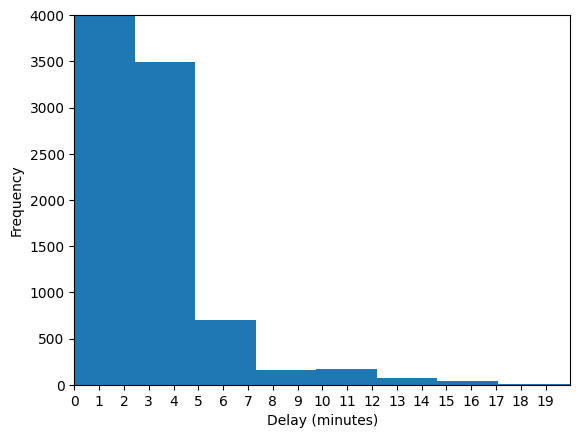

In [18]:
# Plot a histogram of the delay distribution:

plt.hist(df['delay_min'], bins=50)
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')

# Zoom in so that we only look at the delays lower than 20 minutes:
plt.xlim(0, 20)
plt.xticks(range(0, 20, 1))
plt.ylim(0, 4_000)

plt.show()

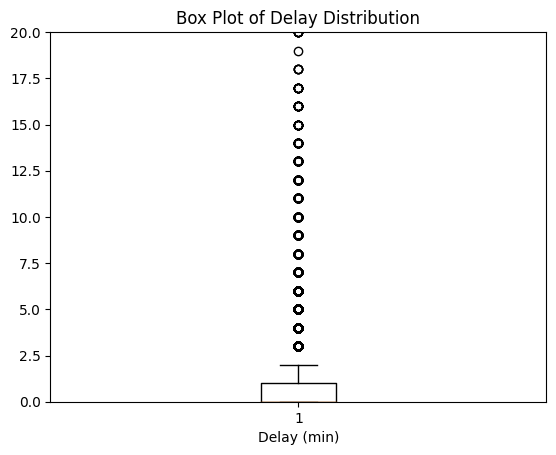

In [19]:
# Create a box plot of the delay_min column
plt.boxplot(df['delay_min'])

# Add a title and labels to the plot
plt.title('Box Plot of Delay Distribution')
plt.xlabel('Delay (min)')

plt.ylim(0, 20)

# Show the plot
plt.show()

#### Some statistics about the distribution

In [20]:
print('mean          ', round(df[COLUMN_DELAY_IN_MIN].mean(), 2))
print('median        ', df[COLUMN_DELAY_IN_MIN].median())
print('min           ', df[COLUMN_DELAY_IN_MIN].min())
print('max           ', df[COLUMN_DELAY_IN_MIN].max())
print('top 75%       ', df[COLUMN_DELAY_IN_MIN].quantile(0.75))
print('lowest 25%    ', df[COLUMN_DELAY_IN_MIN].quantile(0.25))

mean           0.72
median         0.0
min            0.0
max            122.0
top 75%        1.0
lowest 25%     0.0


In [21]:
delay_counts = df.groupby('delay_min').agg({'delay_min': 'count'})

delay_counts

,delay_min
delay_min,
0.0,42535
1.0,8359
2.0,7484
3.0,2528
4.0,966
5.0,387
6.0,193
7.0,118
8.0,87


In [22]:
delays = delay_counts.index.values
counts = delay_counts['delay_min'].values
amount_of_rows = df.shape[0]

print('No delay:', counts[0], f'({round((counts[0] / amount_of_rows) * 100, 1)}%))')
for i in range(1, len(delays)):
    print(f'{delays[i]} min delay:', counts[i], f'({round((counts[i] / amount_of_rows) * 100, 2)}%))')

No delay: 42535 (67.4%))
1.0 min delay: 8359 (13.25%))
2.0 min delay: 7484 (11.87%))
3.0 min delay: 2528 (4.01%))
4.0 min delay: 966 (1.53%))
5.0 min delay: 387 (0.61%))
6.0 min delay: 193 (0.31%))
7.0 min delay: 118 (0.19%))
8.0 min delay: 87 (0.14%))
9.0 min delay: 72 (0.11%))
10.0 min delay: 60 (0.1%))
11.0 min delay: 52 (0.08%))
12.0 min delay: 57 (0.09%))
13.0 min delay: 39 (0.06%))
14.0 min delay: 29 (0.05%))
15.0 min delay: 13 (0.02%))
16.0 min delay: 13 (0.02%))
17.0 min delay: 10 (0.02%))
18.0 min delay: 4 (0.01%))
19.0 min delay: 1 (0.0%))
20.0 min delay: 7 (0.01%))
21.0 min delay: 3 (0.0%))
22.0 min delay: 3 (0.0%))
23.0 min delay: 5 (0.01%))
24.0 min delay: 3 (0.0%))
25.0 min delay: 4 (0.01%))
26.0 min delay: 4 (0.01%))
27.0 min delay: 1 (0.0%))
29.0 min delay: 2 (0.0%))
30.0 min delay: 1 (0.0%))
31.0 min delay: 1 (0.0%))
33.0 min delay: 3 (0.0%))
35.0 min delay: 1 (0.0%))
37.0 min delay: 1 (0.0%))
38.0 min delay: 1 (0.0%))
39.0 min delay: 5 (0.01%))
42.0 min delay: 2 (0.0%

In [23]:
print('This means that how many trains have less than (or equals to) 2 minutes of delay?')

count_less_than_2_min = counts[0] + counts[1] + counts[2]
print('2 or less min delay:', count_less_than_2_min, f'of {amount_of_rows}', f'({round((count_less_than_2_min / amount_of_rows) * 100, 2)}%))')

count_more_than_5_min = sum(counts[5:])
print('more than 5 min delay:', count_more_than_5_min, f'of {amount_of_rows}', f'({round((count_more_than_5_min / amount_of_rows) * 100, 2)}%))')

This means that how many trains have less than (or equals to) 2 minutes of delay?
2 or less min delay: 58378 of 63065 (92.57%))
more than 5 min delay: 1193 of 63065 (1.89%))


### Which locations had to experience the most delays (max) on this day?

C:\Users\Sam\AppData\Local\Temp\ipykernel_15896\3813991389.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(series.index, rotation=90)


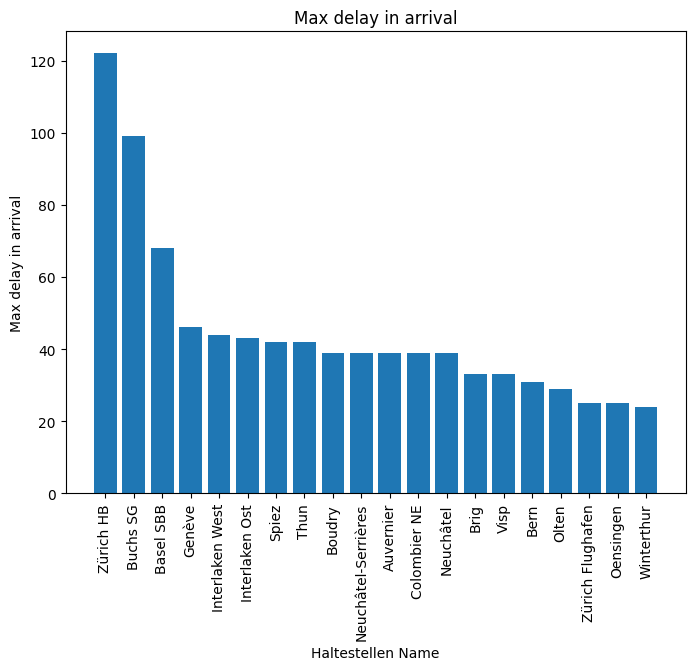

In [24]:

def subplot(label_name, label_value, title, series):


    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(series.index, series.values)
    ax.set_ylabel(label_value)
    ax.set_xlabel(label_name)
    ax.set_xticklabels(series.index, rotation=90)
    ax.set_title(title)
    plt.show()


series = df.groupby(COLUMN_LOCATION)[COLUMN_DELAY_IN_MIN].max()

# Sort the locations by average delay in descending order and select top 10
series = series.sort_values(ascending=True).nlargest(20)
subplot(COLUMN_LOCATION, 'Max delay in arrival', title='Max delay in arrival', series=series)

### Which locations had to experience the most delays on this day **in median**?

C:\Users\Sam\AppData\Local\Temp\ipykernel_15896\3813991389.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(series.index, rotation=90)


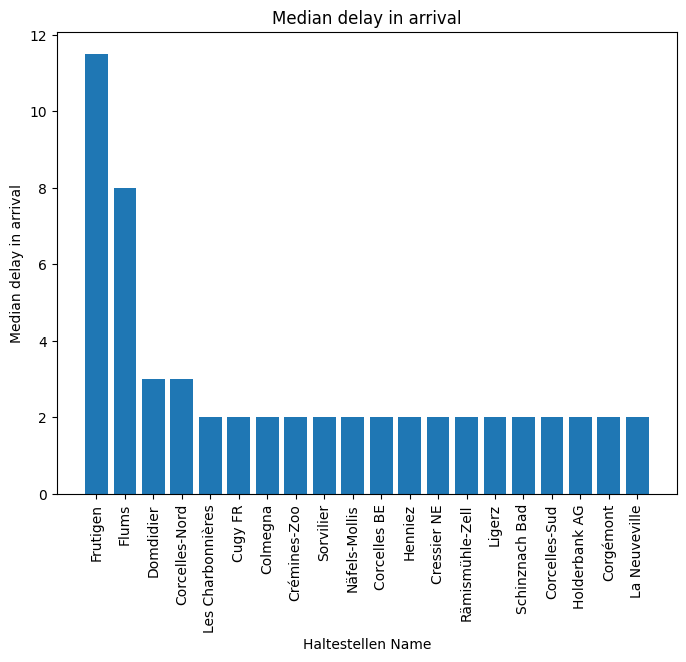

In [25]:
series = df.groupby(COLUMN_LOCATION)[COLUMN_DELAY_IN_MIN].median()

# Sort the locations by average delay in descending order and select top 10
series = series.sort_values(ascending=False).nlargest(20)
subplot(COLUMN_LOCATION, 'Median delay in arrival', title='Median delay in arrival', series=series)

# Data storage (optional)

We can export the calculated delays:

In [27]:
df_export = df[[
    COLUMN_JOURNEY_ID,
    COLUMN_LOCATION,
    COLUMN_ARRIVAL_EXPECTED,
    COLUMN_ARRIVAL_ACTUAL,
    COLUMN_DEPARTURE_EXPECTED,
    COLUMN_DEPARTURE_ACTUAL,
    COLUMN_DELAY_ARRIVAL,
    COLUMN_DELAY_DEPARTURE,
    COLUMN_EARLY_ARRIVAL,
    COLUMN_EARLY_DEPARTURE,]]

df_export.to_excel('./delay_export.xlsx', index=False)


# References

Dataset: [Soll/Ist Vergleich Abfahrts-/Ankunftszeiten SBB](https://data.sbb.ch/explore/dataset/ist-daten-sbb/table/?flg=de&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imxpbmllbl9pZCIsInNjaWVudGlmaWNEaXNwbGF5Ijp0cnVlLCJjb2xvciI6InJhbmdlLUFjY2VudCJ9XSwieEF4aXMiOiJ2ZXJrZWhyc21pdHRlbF90ZXh0IiwibWF4cG9pbnRzIjoyMCwidGltZXNjYWxlIjoiIiwic29ydCI6IiIsInNlcmllc0JyZWFrZG93biI6ImFua3VuZnRzdmVyc3BhdHVuZyIsInN0YWNrZWQiOiJwZXJjZW50IiwiY29uZmlnIjp7ImRhdGFzZXQiOiJpc3QtZGF0ZW4tc2JiIiwib3B0aW9ucyI6eyJmbGciOiJkZSJ9fX1dLCJ0aW1lc2NhbGUiOiIiLCJkaXNwbGF5TGVnZW5kIjp0cnVlLCJhbGlnbk1vbnRoIjp0cnVlfQ%3D%3D)

Older dataset with the same kind of data: https://opentransportdata.swiss/de/dataset/istdaten

Files stored as zip file for the years 2016 - 2023 (2016 and 2017 are incomplete): https://opentransportdata.swiss/de/ist-daten-archiv/